In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import matplotlib.pyplot as plt
import os 
import gseapy as gp
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_network_entropy(exp, grn, significance=0.05, output_dir="./"):
    grn = grn.iloc[:, :-1] ###
    all_samples = list(exp.columns)
    all_genes = list(grn.columns)
    all_tfs = list(grn.index)
    n_samples = len(all_samples)
    n_genes = len(all_genes)
    n_tfs = len(all_tfs)
    tf_pos = [all_genes.index(tf) for tf in all_tfs]
    
    # initialize
    bnet = np.zeros((n_tfs, n_genes), dtype=int)
    net_entropy = np.zeros((n_samples, n_tfs)) 
    exp = np.array(exp.T) # cell * gene
    grn = np.array(grn) # tf * gene
    for i in range(n_tfs):
        cnet = grn[i, :]
        cmean = np.mean(cnet)
        sd = np.std(cnet)
        sig = scipy.stats.norm.ppf(1-significance, cmean, sd)
        cnet[cnet < sig] = 0
        cnet[cnet >= sig] = 1
        bnet[i, :] = cnet
        tmp = cnet * exp
        tmp_s = np.sum(tmp, axis=1)
        tmp_s[tmp_s == 0] = 1
        tmp1 = tmp / tmp_s[:, np.newaxis]
        tmp1[tmp1 == 0] = 1
        net_entropy[:, i] = -np.sum(tmp1 * np.log(tmp1) * exp[:, tf_pos[i]][:, np.newaxis], axis=1)
    
    bnet = pd.DataFrame(bnet, index=all_tfs, columns=all_genes)
    # bnet.to_csv(os.path.join(output_dir, "bnet.csv"))
    
    tf2ntar = [] # TF -> TF(ng)
    for i in range(bnet.shape[0]):
        bnet_i = np.array(bnet.iloc[i, :])
        tf_i_ntar = sum(bnet_i)
        tf2ntar.append(all_tfs[i]+"("+str(tf_i_ntar)+"g)")
    
    net_entropy = pd.DataFrame(net_entropy)
    net_entropy.index = all_samples
    net_entropy.columns = tf2ntar
    # net_entropy.to_csv(os.path.join(output_dir, "net_entropy.csv"))
    return bnet, net_entropy

In [3]:
exp = pd.read_table("filtered_exp.txt", index_col=0, sep="\t")
grn = pd.read_csv("grn500.csv", index_col=0)

In [4]:
bnet, net_entropy = get_network_entropy(exp, grn, significance=0.01)

In [5]:
def prepare_exp_adata(exp, net_entropy, sample_group=None):
    exp_samples = list(exp.columns)
    exp_genes = list(exp.index)
    cellinfo = pd.DataFrame(exp_samples, index=exp_samples)  
    geneinfo = pd.DataFrame(exp_genes, index=exp_genes)  
    if sample_group:
        cellinfo['sample_group'] = sample_group
    # exp
    exp_adata = sc.AnnData(exp.T, obs=cellinfo, var=geneinfo)
    # sc.pp.normalize_total(exp_adata, target_sum=1e4)
    sc.pp.highly_variable_genes(exp_adata, n_top_genes=2000)
    exp_adata.raw = exp_adata
    exp_adata = exp_adata[:, exp_adata.var.highly_variable]
    sc.pp.scale(exp_adata)
    sc.tl.pca(exp_adata, svd_solver='arpack')
    sc.pp.neighbors(exp_adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(exp_adata)
    return exp_adata

In [6]:
def prepare_tf_adata(exp, net_entropy, sample_group=None):
    exp_samples = list(exp.columns)
    cellinfo = pd.DataFrame(exp_samples, index=exp_samples)   
    if sample_group:
        cellinfo['sample_group'] = sample_group
    # tf
    tf_genes = list(net_entropy.columns)
    tf_genes2 = [s.split('(')[0] for s in tf_genes]
    tf_exp = exp.loc[tf_genes2].copy()
    tf_info = geneinfo.loc[tf_genes2]
    tf_adata = sc.AnnData(tf_exp.T, obs=cellinfo, var=tf_info)
    # sc.pp.normalize_total(tf_adata, target_sum=1e4)
    sc.pp.scale(tf_adata)
    sc.tl.pca(tf_adata, svd_solver='arpack')
    sc.pp.neighbors(tf_adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(tf_adata)
    return tf_adata

In [7]:
def prepare_entropy_adata(exp, net_entropy, sample_group=None):
    exp_samples = list(exp.columns)
    cellinfo = pd.DataFrame(exp_samples, index=exp_samples)  
    if sample_group:
        cellinfo['sample_group'] = sample_group
    # entropy
    entropy_tf = list(net_entropy.columns)
    tf_name = [s.split('(')[0] for s in entropy_tf]
    entropy_tfinfo = pd.DataFrame({'tf_name': tf_name}, index=entropy_tf)  
    entropy_adata = sc.AnnData(net_entropy, obs=cellinfo, var=entropy_tfinfo)
    sc.pp.normalize_total(entropy_adata, target_sum=1e4)
    sc.pp.scale(entropy_adata)
    sc.tl.pca(entropy_adata, svd_solver='arpack')
    sc.pp.neighbors(entropy_adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(entropy_adata)
    return entropy_adata

## UMAP

In [8]:
all_samples = list(exp.columns)
all_genes = list(grn.columns)
all_tfs = list(grn.index)
sample_group = [name[0:6] for name in all_samples]
cellinfo = pd.DataFrame(all_samples, index=all_samples)  
cellinfo['sample_group'] = sample_group
geneinfo = pd.DataFrame(all_tfs, index=all_tfs)  

In [9]:
exp_adata = prepare_exp_adata(exp, net_entropy, sample_group)

In [10]:
exp_adata

AnnData object with n_obs × n_vars = 758 × 2000
    obs: 0, 'sample_group'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

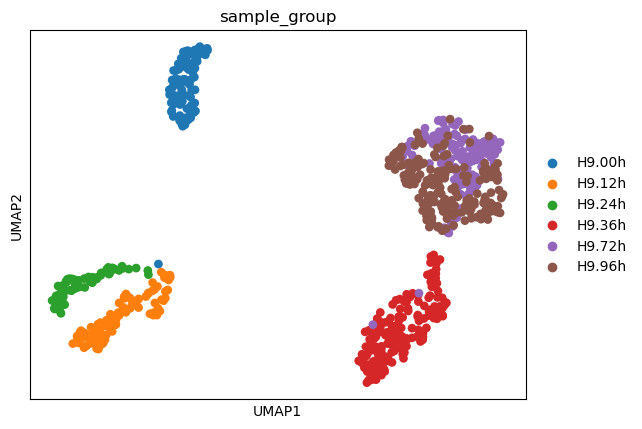

In [11]:
sc.pl.umap(exp_adata, color="sample_group")

## TF cluster

In [28]:
tf_adata = prepare_tf_adata(exp, net_entropy, sample_group)

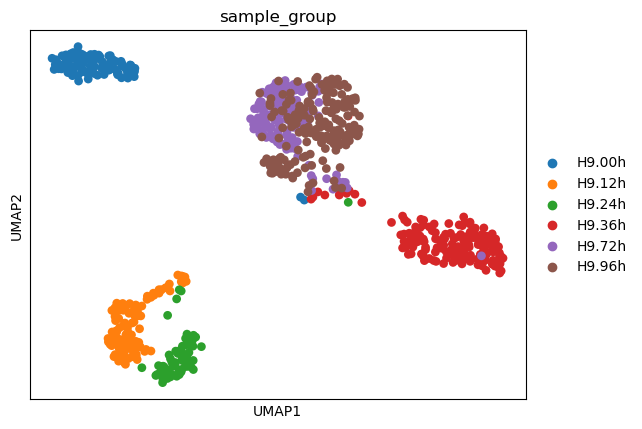

In [13]:
sc.pl.umap(tf_adata, color="sample_group")

In [54]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import LinearSegmentedColormap
# colors = ["blue", "white", "red"] 
# cmap = LinearSegmentedColormap.from_list("bwr_custom", colors)
# sc.pl.heatmap(tf_adata, var_names=tf_adata.var_names, groupby='sample_group', cmap=cmap, dendrogram=True)

In [15]:
sc.tl.rank_genes_groups(tf_adata, 'sample_group', method='wilcoxon')

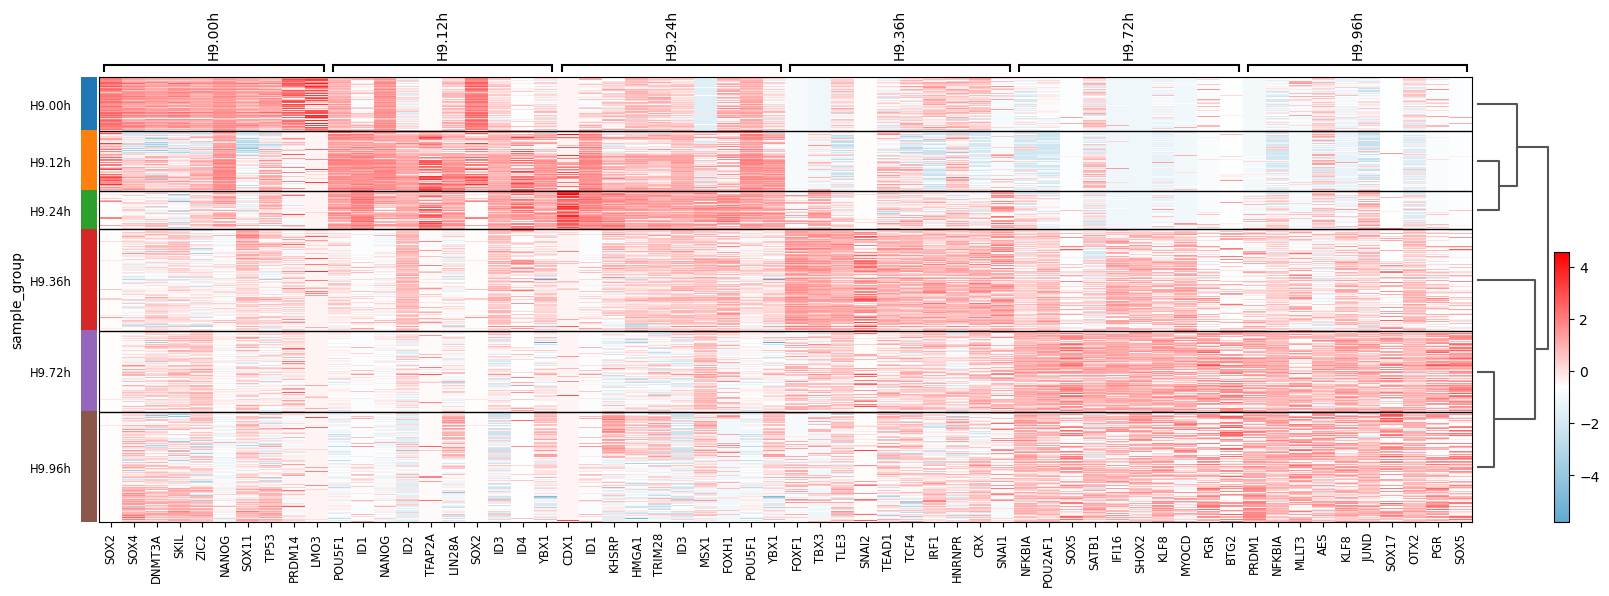

In [35]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
colors = ["#61AACF", "white", "red"] 
cmap = LinearSegmentedColormap.from_list("bwr_custom", colors)
sc.pl.rank_genes_groups_heatmap(tf_adata, n_genes=10, show_gene_labels=True, cmap=cmap)

## TF GRN

In [10]:
entropy_adata = prepare_entropy_adata(exp, net_entropy, sample_group)

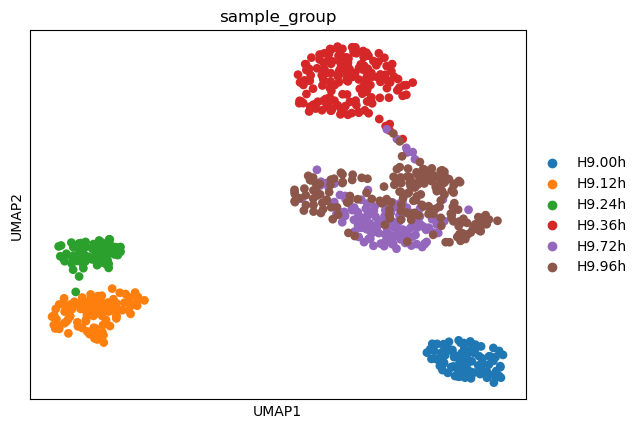

In [11]:
sc.pl.umap(entropy_adata, color="sample_group")

In [40]:
sc.tl.rank_genes_groups(entropy_adata, 'sample_group', method='t-test')

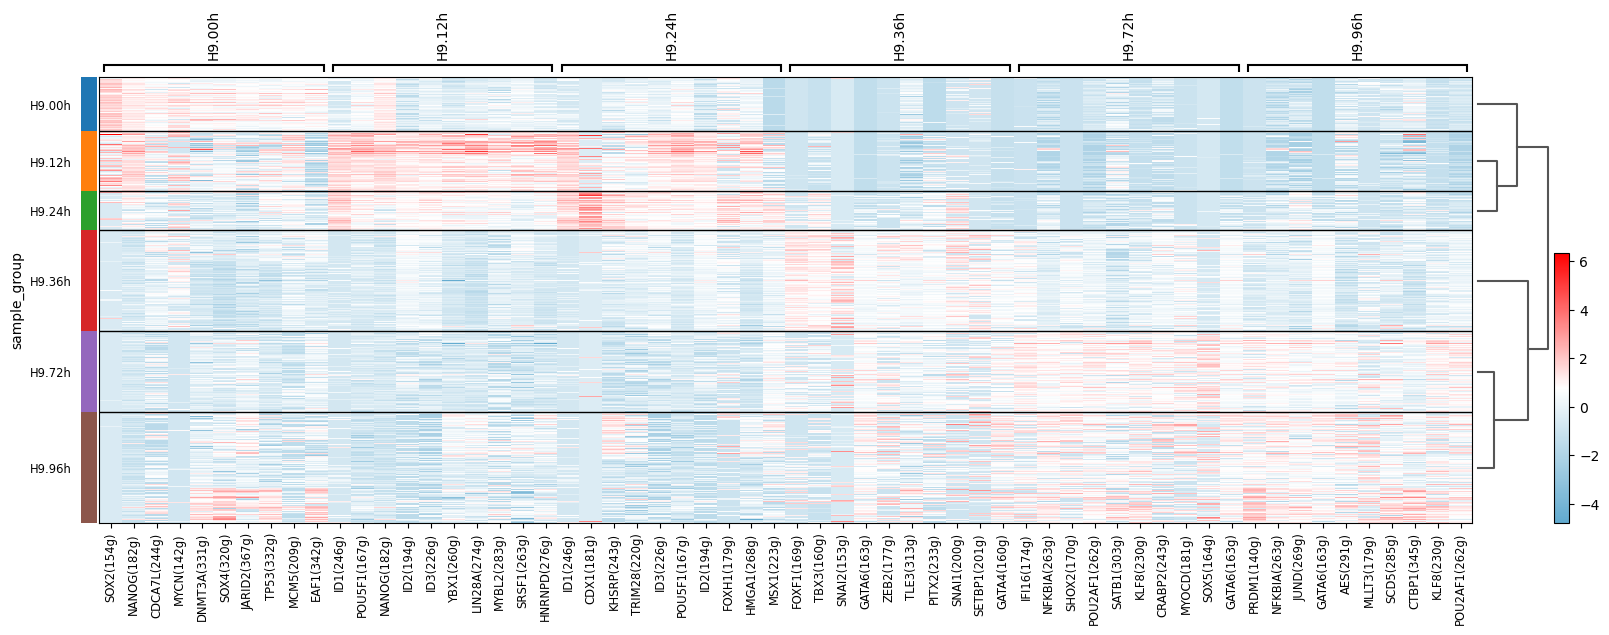

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
colors = ["#61AACF", "white", "red"]  #CF3132
cmap = LinearSegmentedColormap.from_list("bwr_custom", colors)
sc.pl.rank_genes_groups_heatmap(entropy_adata, n_genes=10, show_gene_labels=True, cmap=cmap)

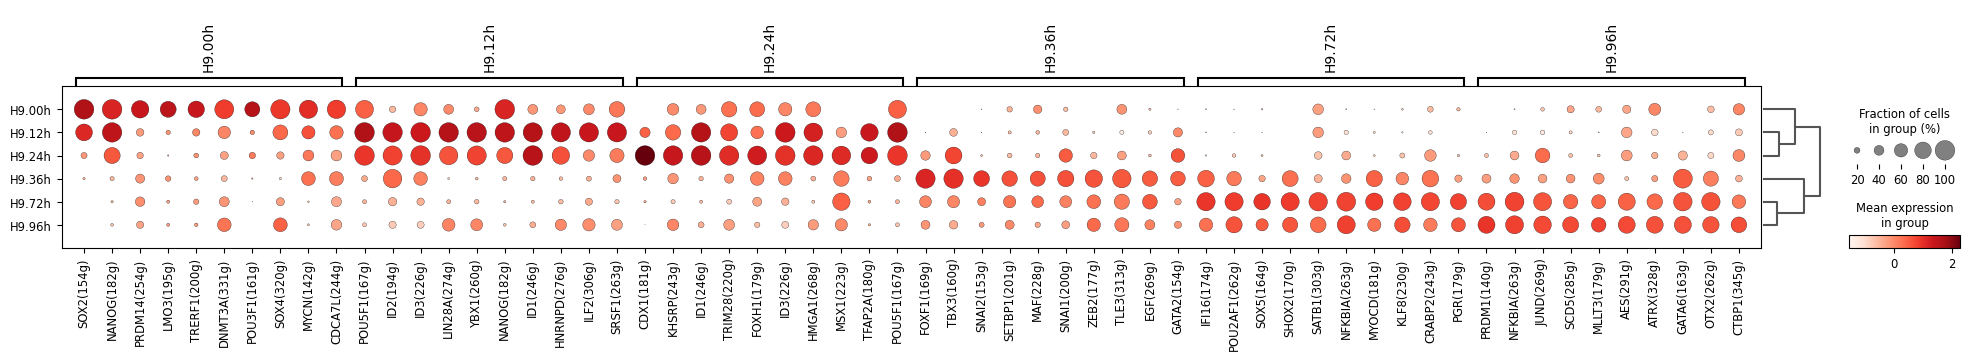

In [23]:
sc.pl.rank_genes_groups_dotplot(entropy_adata, n_genes=10)

## Network

In [86]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [107]:
# def generate_pastel_hex_colors(n):
#     # Generate pastel colors by adding white and converting to hex
#     colors = np.clip((np.random.rand(n, 3) + np.array([1, 1, 1])) / 2, 0, 1)
#     return ['#' + ''.join(f'{int(c*255):02x}' for c in color) for color in colors]

def generate_pastel_color():
    return [np.random.uniform(0.6, 0.9) for _ in range(3)]

def rgb_to_hex(rgb):
    return mcolors.to_hex(rgb)

def generate_pastel_hex_colors(n):
    colors_rgb = [generate_pastel_color() for _ in range(n)]
    colors_hex = [rgb_to_hex(color) for color in colors_rgb]
    return colors_hex

def plot_tf_network(bnet, grn, tf_list):
    G = nx.DiGraph()
    shown_nodes = []
    for tf_name in tf_list:
        # add node
        tf_net = bnet.loc[tf_name, :]
        target_gene = list(tf_net[tf_net == 1].index)
        G.add_node(tf_name, category=tf_name)
        shown_nodes.append(tf_name)
        # hide node 
        mi_net = grn.loc[tf_name]
        mi_net = mi_net.loc[target_gene]
        mi_net = mi_net.sort_values(ascending=False)
        for i in range(mi_net.shape[0]):
            if i < mi_net.shape[0]*0.5:
                G.add_node(mi_net.index[i], category=tf_name)
                G.add_edge(tf_name, mi_net.index[i], minlen=min(mi_net.iloc[i]*3, 1)) # 
                if i < mi_net.shape[0]*0.1:
                    shown_nodes.append(mi_net.index[i])
    colors = generate_pastel_hex_colors(len(tf_list))
    font_size_dict = {node: (18 if node in tf_list else 9) for node in G.nodes()}
    node_colors = {k:v for k, v in zip(tf_list, colors)}
    edge_colors = [node_colors.get(G.nodes[source]['category'], 'gray') for source, _ in G.edges]
    edge_weights = nx.get_edge_attributes(G, 'minlen')
    # get layout
    plt.figure(figsize=(15, 10))
    pos = graphviz_layout(G, prog='neato')
    # pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color=[node_colors.get(G.nodes[node]['category'], 'gray') for node in G], 
                          node_size=5)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=False
                          , alpha=[edge_weights[edge] for edge in G.edges]) # width=[edge_weights[edge] for edge in G.edges], 
    for node, font_size in font_size_dict.items():
        if node in shown_nodes:
            nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)
    plt.axis('off')
    plt.show()

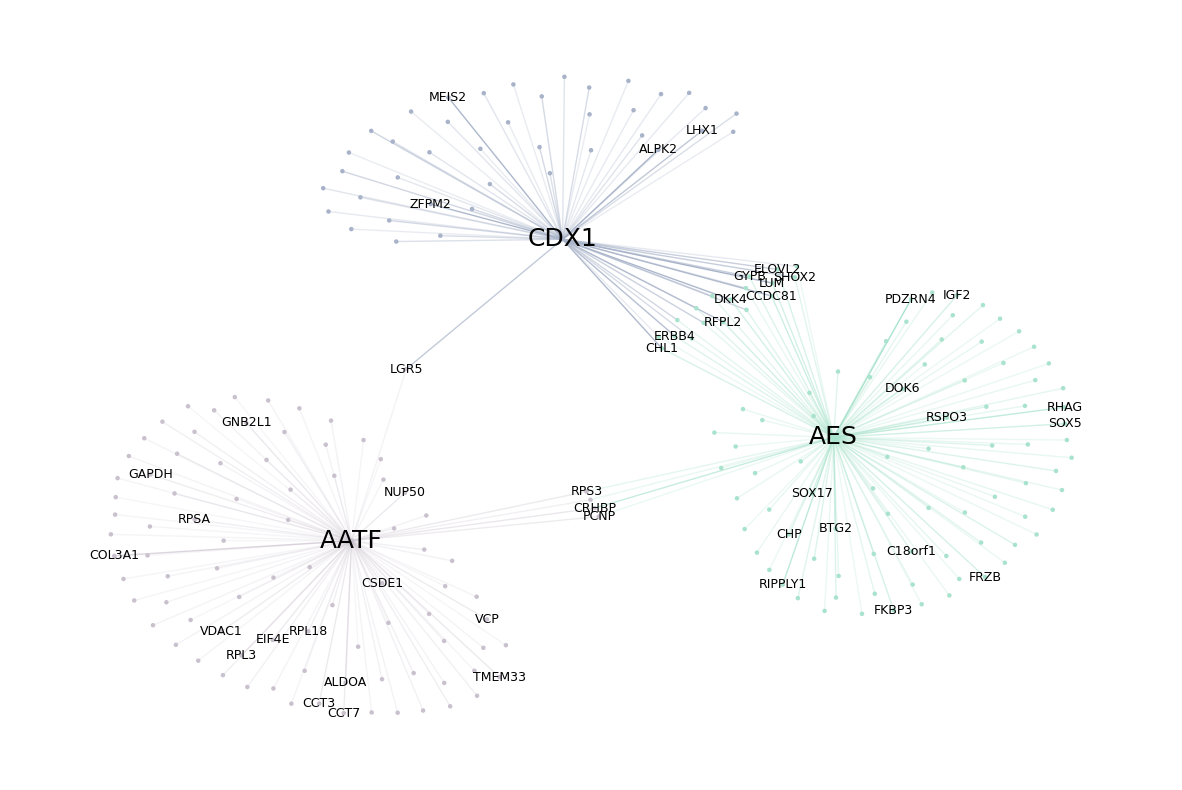

In [108]:
plot_tf_network(bnet, grn, ["CDX1", "AES", "AATF"]) # , "SOX2", "CDX1"

## Enrichment

In [93]:
from gseapy import barplot, dotplot
def enrichment(bnet, tf_name, organism='human'):
    tf_net = bnet.loc[tf_name, :]
    target_gene = list(tf_net[tf_net == 1].index)
    gene_sets = "KEGG_2019_Human" if organism == "human" else "KEGG_2019_Mouse"
    enr = gp.enrichr(gene_list=target_gene, 
                 gene_sets=gene_sets,
                 organism=organism, 
                 outdir=None,
                )
    # ax = dotplot(enr.res2d, title='AATF',cmap='viridis_r', size=10, figsize=(3,5))
    ax = barplot(enr.res2d, title=tf_name, figsize=(4, 5), color='darkred')
    return enr

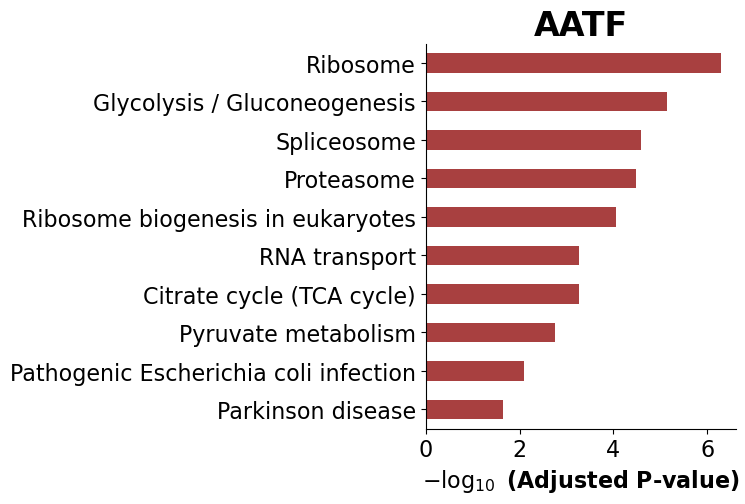

In [21]:
enr = enrichment(bnet, "AATF")

## TF activity UMAP

In [18]:
def plot_activity_umap(entropy_adata, tf_list):
    tfname_ntar = list(entropy_adata.var.index)
    tfname = list(entropy_adata.var.tf_name)
    tfname_dict = {k:v for k, v in zip(tfname, tfname_ntar)}
    sc.pl.umap(entropy_adata, color=[tfname_dict[i] for i in tf_list])

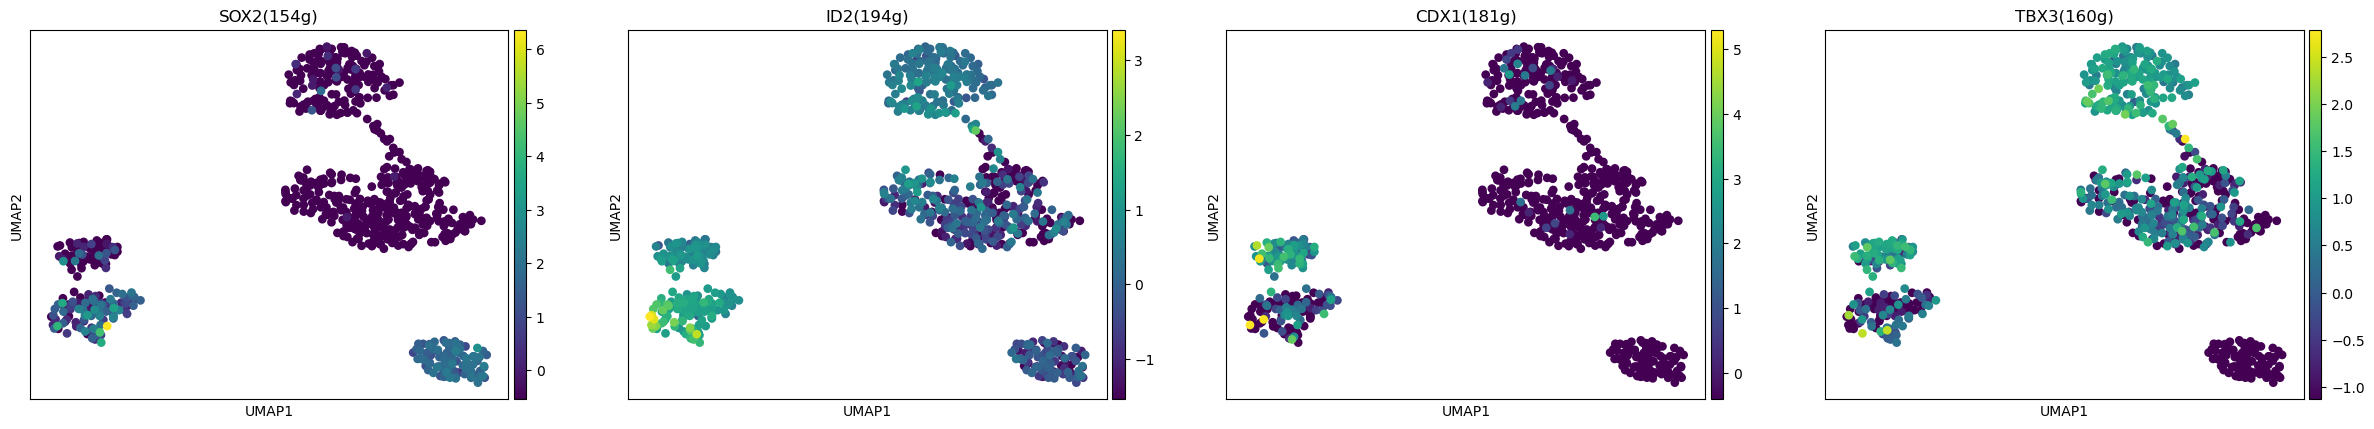

In [19]:
plot_activity_umap(entropy_adata, ["SOX2", "ID2", "CDX1", "TBX3"])